# Alignment Quantification
This notebook is meant to quantitatively measure the effects of our alignment algorithm.

It uses both the mean square error (MSE) and a structural similarity measure (SSIM) to measure the effectiveness of our alignment algorithm and to compare the performance of ORB and SIFT keypoint detections. ORB provides very slight improvements and runs faster so we use that for the rest of the project.

In the comparison between ORB and SIFT, another metric was used. It was the ratio of the number of keypoints kept by RANSAC to the number of keypoints found by the SIFT or ORB.
Higher ratio is interpreted as better as it suggest that more of the matches that were found by the keypoint detection algorithm were useful in creating the homographic projection for alignment.

In [29]:
%load_ext autoreload
%autoreload 2
import cv2

from utils.alignment import get_image_alignment_transform
from utils.alignment import apply_transform
from utils.alignment import crop_zero_sides
from utils.dataset_navigation import get_image_paths
import rawpy
from utils.raw_utils import pack_raw
import numpy as np
from tqdm import tqdm 
import skimage


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Calculate statistics for aligned images

In [32]:

def calculate_alignment_statistics( method: str ):
    raw_image_paths = get_image_paths()
    long_exp_paths = raw_image_paths['long_exp']
    filtered_paths = raw_image_paths['filter_long_exp']
    n = len(long_exp_paths)
    ratios = np.zeros(n)
    mses = np.zeros(n)
    ssims = np.zeros(n)
    for idx, (long_path, filtered_path) in tqdm(enumerate(zip(long_exp_paths, filtered_paths)), total=n):
        # Load raw images into 4 channels
        long_packed = pack_raw(rawpy.imread(long_path).raw_image_visible, normalize=True)
        filtered_packed = pack_raw(rawpy.imread(filtered_path).raw_image_visible, normalize=True)
        # Rescale for alignment algs
        long_g = (long_packed[:,:,1]/long_packed[:,:,1].max()*255).astype(np.uint8)
        filtered_g = (filtered_packed[:,:,1]/filtered_packed[:,:,1].max()*255).astype(np.uint8)
        # Align and crop
        try:
            H, ratio = get_image_alignment_transform(long_g, filtered_g, method, return_ratio=True)
            aligned = apply_transform(long_packed, filtered_packed, H)
            long_packed, aligned = crop_zero_sides(long_packed, aligned, 100)
        except Exception as e:
            mses[idx] = -1
            ssims[idx] = -1
            ratios[idx] = -1
            print("Skipping because of:", e)
            continue
        # Calculate metrics
        diff = long_packed.astype(np.float64) - aligned.astype(np.float64)
        mses[idx] = np.mean(diff**2)
        ssims[idx] = skimage.metrics.structural_similarity(long_packed, aligned, channel_axis=2, data_range=aligned.max()-aligned.min())
        ratios[idx] = ratio
        
    return ratios, ssims, mses
    

In [33]:
ratios_orb, ssims_orb, mses_orb = calculate_alignment_statistics('orb')


Processing folder: ../dataset_raw/filter_long_exp
Processing folder: ../dataset_raw/long_exp
Processing folder: ../dataset_raw/short_exp


  1%|▏         | 3/237 [00:15<20:08,  5.17s/it]


KeyboardInterrupt: 

In [22]:
ratios_sift, ssims_sift, mses_sift = calculate_alignment_statistics('sift')


 40%|████      | 95/237 [04:24<05:50,  2.47s/it]

Skipping because of: Not enough matches (3) for homography.


 53%|█████▎    | 125/237 [05:47<04:47,  2.57s/it]

Skipping because of: Not enough matches (3) for homography.


 53%|█████▎    | 126/237 [05:49<04:22,  2.37s/it]

Skipping because of: Not enough matches (3) for homography.


 54%|█████▎    | 127/237 [05:51<04:02,  2.21s/it]

Skipping because of: RANSAC failed to find a valid homography.


100%|██████████| 237/237 [10:54<00:00,  2.76s/it]


In [39]:
def sanitize(array):
    return array[array!=-1]
ratios_orb = sanitize(ratios_orb)
ssims_orb = sanitize(ssims_orb)
mses_orb = sanitize(mses_orb)
ratios_sift = sanitize(ratios_sift)
ssims_sift = sanitize(ssims_sift)
mses_sift = sanitize(mses_sift)


In [23]:
# Count how many images were skipped due to alignment errors
print("ORB skipped images:", (ratios_orb == -1).sum())
print("SIFT skipped images:", (ratios_sift == -1).sum())

ORB skipped images: 0
SIFT skipped images: 4


## Calculate statistics for unaligned images

In [26]:
# Same statistics but on unaligned images:
def calculate_unalignment_statistics():
    raw_image_paths = get_image_paths()
    long_exp_paths = raw_image_paths['long_exp']
    filtered_paths = raw_image_paths['filter_long_exp']
    n = len(long_exp_paths)
    mses = np.zeros(n)
    ssims = np.zeros(n)
    for idx, (long_path, filtered_path) in tqdm(enumerate(zip(long_exp_paths, filtered_paths)), total=n):
        # Load raw images into 4 channels
        long_packed = pack_raw(rawpy.imread(long_path).raw_image_visible, normalize=True)
        filtered_packed = pack_raw(rawpy.imread(filtered_path).raw_image_visible, normalize=True)
        # Calculate metrics
        diff = long_packed.astype(np.float64) - filtered_packed.astype(np.float64)
        mses[idx] = np.mean(diff**2)
        ssims[idx] = skimage.metrics.structural_similarity(long_packed, filtered_packed, channel_axis=2, data_range=filtered_packed.max()-filtered_packed.min())
    return ssims, mses

In [27]:
ssims, mses = calculate_unalignment_statistics()

100%|██████████| 237/237 [07:30<00:00,  1.90s/it]


## Performances compared

In [158]:
print("Mean ratio [ORB]:", ratios_orb.mean(), "(higher is better)")
print("Mean ratio [SIFT]:", ratios_sift.mean(), "(higher is better)")
print("Mean SSIM [ORB]:", ssims_orb.mean(), "(higher is better)")
print("Mean SSIM [None]:", ssims.mean(), "(higher is better)")
print("Mean SSIM [SIFT]:", ssims_sift.mean(), "(higher is better)")
print("Mean MSE [None]:", mses.mean(), "(lower is better)")
print("Mean MSE [ORB]:", mses_orb.mean(), "(lower is better)")
print("Mean MSE [SIFT]:", mses_sift.mean(), "(lower is better)")

Mean ratio [ORB]: 0.8113638830205411 (higher is better)
Mean ratio [SIFT]: 0.7078840678375469 (higher is better)
Mean SSIM [ORB]: 0.9887630179117572 (higher is better)
Mean SSIM [None]: 0.9621829025018456 (higher is better)
Mean SSIM [SIFT]: 0.9311361135632926 (higher is better)
Mean SSIM [None]: 0.9311361135632926 (higher is better)
Mean MSE [None]: 1470965.9330760096 (lower is better)
Mean MSE [ORB]: 317084.15090020536 (lower is better)
Mean MSE [SIFT]: 321847.1979154305 (lower is better)


In [159]:
# header
print(f"{'Idx':>3}  {'ORB R':>7}  {'ORB SSIM':>9}  {'ORB MSE':>9}   |   {'SIFT R':>7}  {'SIFT SSIM':>9}  {'SIFT MSE':>9}")
print("-"*80)

# rows
for i, (ro, so, mo, rs, ss, ms) in enumerate(zip(
        ratios_orb, ssims_orb, mses_orb,
        ratios_sift, ssims_sift, mses_sift)):
    print(f"{i:3d}  {ro:7.3f}  {so:9.3f}  {mo:9.2f}   |   {rs:7.3f}  {ss:9.3f}  {ms:9.2f}")

Idx    ORB R   ORB SSIM    ORB MSE   |    SIFT R  SIFT SSIM   SIFT MSE
--------------------------------------------------------------------------------
  0    0.750      0.979  847291.87   |     0.665      0.978  865551.16
  1    0.905      0.976  444442.40   |     0.791      0.977  451022.73
  2    0.687      0.985  447662.25   |     0.780      0.985  448148.37
  3    0.499      0.972  910332.43   |     0.547      0.973  905366.47
  4    0.344      0.888  2841478.52   |     0.457      0.936  1566949.19
  5    0.931      0.988  866150.26   |     0.781      0.988  862936.97
  6    0.975      0.990  259843.72   |     0.895      0.990  259638.60
  7    0.860      0.992  199075.78   |     0.871      0.992  196578.77
  8    0.935      0.998   22068.14   |     0.865      0.998   21256.86
  9    0.778      0.973  393702.89   |     0.506      0.978  372360.83
 10    0.737      0.991  194232.43   |     0.653      0.991  194510.50
 11    0.906      0.996   35419.67   |     0.851      0.995   375

In [30]:
# Calculate the mean of the ratios, SSIMs and MSEs

mean_ratios_orb = ratios_orb[ ratios_orb != -1].mean()
mean_ssims_orb = ssims_orb[ ssims_orb != -1].mean()
mean_mses_orb = mses_orb[ mses_orb != -1].mean()
mean_ratios_sift = ratios_sift[ ratios_sift != -1].mean()
mean_ssims_sift = ssims_sift[ ssims_sift != -1].mean()
mean_mses_sift = mses_sift[ mses_sift != -1].mean()
mean_ssims = ssims[ ssims != -1].mean()
mean_mses = mses[ mses != -1].mean()
print(f"Mean ratio [ORB]:  {mean_ratios_orb:.3f} (higher is better)")
print(f"Mean ratio [SIFT]: {mean_ratios_sift:.3f} (higher is better)")
print(f"Mean SSIM [ORB]:   {mean_ssims_orb:.3f} (higher is better)")
print(f"Mean SSIM [SIFT]:  {mean_ssims_sift:.3f} (higher is better)")
print(f"Mean SSIM [None]:  {mean_ssims:.3f} (higher is better)")
print(f"Mean MSE [None]:   {mean_mses:.5f} (lower is better)")
print(f"Mean MSE [ORB]:    {mean_mses_orb:.5f} (lower is better)")
print(f"Mean MSE [SIFT]:   {mean_mses_sift:.5f} (lower is better)")




Mean ratio [ORB]:  0.794 (higher is better)
Mean ratio [SIFT]: 0.758 (higher is better)
Mean SSIM [ORB]:   0.947 (higher is better)
Mean SSIM [SIFT]:  0.943 (higher is better)
Mean SSIM [None]:  0.907 (higher is better)
Mean MSE [None]:   0.00478 (lower is better)
Mean MSE [ORB]:    0.00215 (lower is better)
Mean MSE [SIFT]:   0.00595 (lower is better)


### From here on out we only compare the results from ORB to the unaligned images

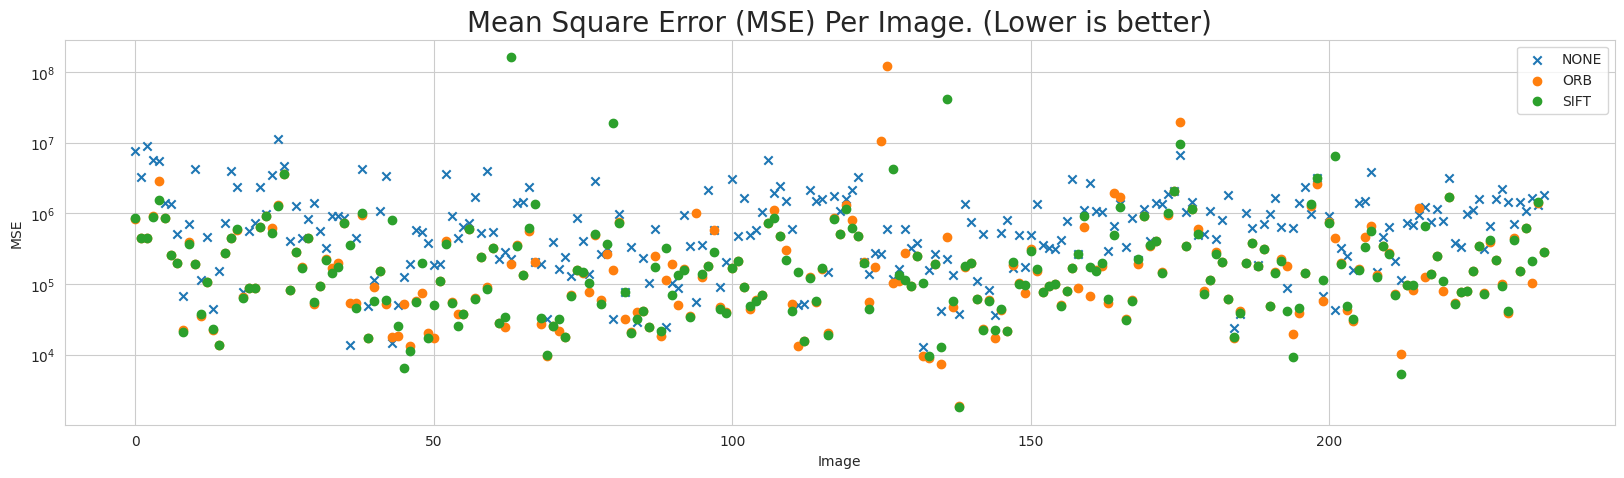

In [14]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20,5))
# plt.yscale('log')
plt.scatter(range(len(mses_sift)), mses, label="NONE", marker='x')
plt.scatter(range(len(mses_orb)), mses_orb, label="ORB")
plt.scatter(range(len(mses_sift)), mses_sift, label="SIFT")
plt.legend()
# log
plt.yscale('log')
plt.title("Mean Square Error (MSE) Per Image. (Lower is better)", {'fontsize':20})
plt.xlabel("Image")
plt.ylabel("MSE")
plt.show()

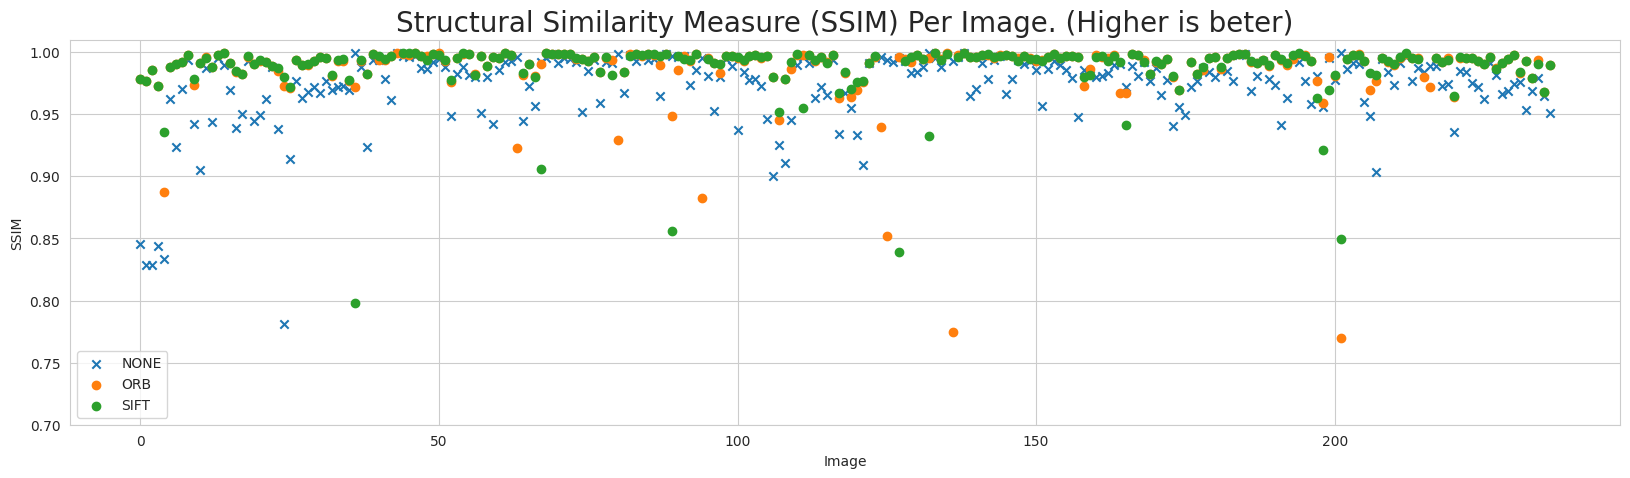

In [15]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20,5))
plt.ylim((0.7, 1.01))
plt.scatter(range(len(ssims_sift)), ssims, label="NONE", marker='x')
plt.scatter(range(len(ssims_orb)), ssims_orb, label="ORB")
plt.scatter(range(len(mses_sift)), ssims_sift, label="SIFT")
plt.legend()
plt.title("Structural Similarity Measure (SSIM) Per Image. (Higher is beter)", {'fontsize':20})
plt.xlabel("Image")
plt.ylabel("SSIM")
plt.show()

In [ ]:

def calculate_alignment_statistics( method: str ):
    raw_image_paths = get_image_paths()
    long_exp_paths = raw_image_paths['long_exp']
    filtered_paths = raw_image_paths['filter_long_exp']
    n = len(long_exp_paths)
    ratios = np.zeros(n)
    mses = np.zeros(n)
    ssims = np.zeros(n)
    for idx, (long_path, filtered_path) in tqdm(enumerate(zip(long_exp_paths, filtered_paths)), total=n):
        # Load raw images into 4 channels
        long_packed = pack_raw(rawpy.imread(long_path).raw_image_visible)
        filtered_packed = pack_raw(rawpy.imread(filtered_path).raw_image_visible)
        # Rescale for alignment algs
        long_g = (long_packed[:,:,1]/long_packed[:,:,1].max()*255).astype(np.uint8)
        filtered_g = (filtered_packed[:,:,1]/filtered_packed[:,:,1].max()*255).astype(np.uint8)
        # Align and crop
        try:
            H, ratio = get_image_alignment_transform(long_g, filtered_g, method, return_ratio=True)
            aligned = apply_transform(long_packed, filtered_packed, H)
            long_packed, aligned = crop_zero_sides(long_packed, aligned, 100)
        except Exception as e:
            mses[idx] = -1
            ssims[idx] = -1
            ratios[idx] = -1
            print("Skipping because of:", e)
            continue
        # Calculate metrics
        diff = long_packed.astype(np.float64) - aligned.astype(np.float64)
        mses[idx] = np.mean(diff**2)
        ssims[idx] = skimage.metrics.structural_similarity(long_packed, aligned, channel_axis=2)
        ratios[idx] = ratio

    return ratios, ssims, mses

In [85]:

mses_sorted = mses_orb.argsort()[::-1]
ssims_sorted = ssims_orb.argsort()
ratios_sorted = ratios_orb.argsort()
k = 10
print("Images sorted worse to best MSE, SSIM and ratio")
print(f"MSEs: {mses_sorted[:k]} ... {mses_sorted[-k:]}")
print(f"SSIMs: {ssims_sorted[:k]} ... {ssims_sorted[-k:]}")
print(f"Ratios: {ratios_sorted[:k]} ... {ratios_sorted[-k:]}")

MSEs: [25  4 24 38 22  3  5  0 35 21] ... [71 49 44 43 72 50 39 14 46 69]
SSIMs: [ 4 63 25 36  3 24  9 52  1 35] ... [71 70 69 54 14 61 68 43 50 46]
Ratios: [ 4 35  3 63 66 28 47 58 53  2] ... [ 8 74 13 14 17 12 21 39 26  6]


In [34]:
# Visualize image alignment:
import cv2 as cv
import numpy as np
from utils.alignment import demosaic_bilinear
from utils.alignment import align_and_crop_raw_images

def normalize(img, min=None, max=None):
    if min is None:
        min = img.min()
    if max is None:
        max = img.max()
    return ((img - min) / (max - min)*255).astype(np.uint8)

def visualize_alignment(idx, method='orb'):
    raw_image_paths = get_image_paths()
    long_path = raw_image_paths['long_exp'][idx]
    filtered_path = raw_image_paths['filter_long_exp'][idx]
    # Rescale for alignment algs
    long_aligned_result, filtered_aligned_result = align_and_crop_raw_images(long_path, filtered_path)
    long_rgb, filtered_rgb = long_aligned_result['rgb'], filtered_aligned_result['rgb']
    long_rgb = normalize(long_rgb)
    filtered_rgb = normalize(filtered_rgb)

    long_gray = cv.cvtColor(long_rgb, cv.COLOR_RGB2GRAY)
    filtered_gray = cv.cvtColor(filtered_rgb, cv.COLOR_RGB2GRAY)
    threshold_1 = 50
    threshold_2 = 20
    long_edges = cv.Canny(long_gray, threshold_1,threshold_2)
    filtered_edges = cv.Canny(filtered_gray, threshold_1, threshold_2)

    edges_combined = np.zeros((long_edges.shape[0], long_edges.shape[1], 3))
    edges_combined[:,:,0] = long_edges
    edges_combined[:,:,1] = filtered_edges

    fig, axs = plt.subplots(3,2, figsize=(10,15))
    axs[0,0].imshow(normalize(demosaic_bilinear(rawpy.imread(long_path).raw_image_visible)))
    axs[0,1].imshow(normalize(demosaic_bilinear(rawpy.imread(filtered_path).raw_image_visible)))
    axs[1,0].imshow(long_rgb)
    axs[1,1].imshow(filtered_rgb)
    axs[2,0].imshow(np.abs(long_gray-filtered_gray),  cmap='viridis')
    axs[2,1].imshow(edges_combined)
    plt.show()

In [35]:
visualize_alignment(39)

Processing folder: ../dataset_raw/filter_long_exp
Processing folder: ../dataset_raw/long_exp
Processing folder: ../dataset_raw/short_exp


NameError: name 'plt' is not defined

In [149]:
from utils.alignment import align_and_crop_raw_images

def calculate_alignment_mmsis_different_sigmas():
    raw_image_paths = get_image_paths()
    long_exp_paths = raw_image_paths['long_exp']
    filtered_paths = raw_image_paths['filter_long_exp']
    n = len(long_exp_paths)
    sigmas = [0.5, 1, 1.5, 2, 4, 8]
    ssims = [np.zeros(n) for _ in range(len(sigmas))] 
    
    for idx, (long_path, filtered_path) in tqdm(enumerate(zip(long_exp_paths, filtered_paths)), total=n):
        # Load raw images into 4 channels
        long_packed = pack_raw(rawpy.imread(long_path).raw_image_visible)
        filtered_packed = pack_raw(rawpy.imread(filtered_path).raw_image_visible)
        # Rescale for alignment algs
        long_g = (long_packed[:,:,1]/long_packed[:,:,1].max()*255).astype(np.uint8)
        filtered_g = (filtered_packed[:,:,1]/filtered_packed[:,:,1].max()*255).astype(np.uint8)
        # Align and crop
        try:
            H, ratio = get_image_alignment_transform(long_g, filtered_g, 'orb', return_ratio=True)
            aligned = apply_transform(long_packed, filtered_packed, H)
            long_packed, aligned = crop_zero_sides(long_packed, aligned, 100)
        except Exception as e:
            print("Skipping because of:", e)
            continue
        # Calculate metrics
        for s_idx, sigma in enumerate(sigmas):
            ssims[s_idx][idx] = skimage.metrics.structural_similarity(long_packed, aligned, channel_axis=2, sigma=sigma, gaussian_weights=True)

    return ssims

In [150]:
ssims = calculate_alignment_mmsis_different_sigmas()

100%|██████████| 77/77 [10:36<00:00,  8.27s/it]


In [152]:
sigmas = [0.5, 1, 1.5, 2, 4, 8]
for idx, sigma in enumerate(sigmas):
    print(f"sigma: {sigma} has avg ssim {ssims[idx].mean()}")

sigma: 0.5 has avg ssim 0.991294978863248
sigma: 1 has avg ssim 0.9898541235451246
sigma: 1.5 has avg ssim 0.9892221974486465
sigma: 2 has avg ssim 0.9888120853592223
sigma: 4 has avg ssim 0.9878315796786162
sigma: 8 has avg ssim 0.9868858987300853


## Visualize the aligned images 

Use a checkboard pattern to visualize the alignment.

In [36]:
import cv2 as cv
import numpy as np
from utils.alignment import demosaic_bilinear
from utils.alignment import align_and_crop_raw_images
from matplotlib import pyplot as plt
import skimage

def visualize_alignment_checkerboard(idx, method='orb'):
    
    raw_image_paths = get_image_paths()
    long_path = raw_image_paths['long_exp'][idx]
    filtered_path = raw_image_paths['filter_long_exp'][idx]
    # Rescale for alignment algs
    long_aligned_result, filtered_aligned_result = align_and_crop_raw_images(long_path, filtered_path)
    long_rgb, filtered_rgb = long_aligned_result['rgb'], filtered_aligned_result['rgb']
    
    min_val = min(long_rgb.min(), filtered_rgb.min())
    max_val = max(long_rgb.max(), filtered_rgb.max())
    
    long_rgb = normalize(long_rgb, min_val, max_val)
    filtered_rgb = normalize(filtered_rgb, min_val, max_val)

    long_gray = cv.cvtColor(long_rgb, cv.COLOR_RGB2GRAY)
    filtered_gray = cv.cvtColor(filtered_rgb, cv.COLOR_RGB2GRAY)
    
    # Create a checkboard pattern
    checkboard_size = 20
    combined = skimage.util.compare_images(long_gray, filtered_gray, method='checkerboard', n_tiles=(checkboard_size,checkboard_size))
    plt.imshow(combined, cmap='gray')


Processing folder: ../dataset_raw/filter_long_exp
Processing folder: ../dataset_raw/long_exp
Processing folder: ../dataset_raw/short_exp


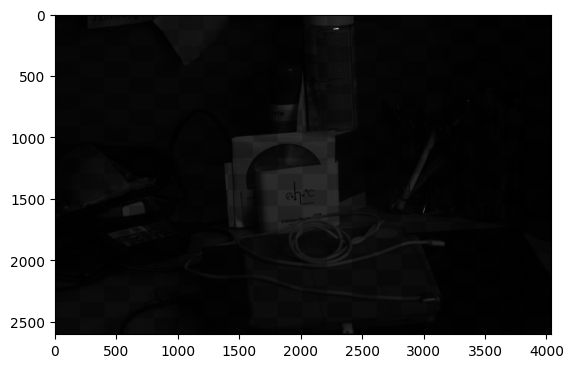

In [37]:
visualize_alignment_checkerboard(39)